In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [8]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS =50


In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [10]:
#for get 3 classes of images
class_names = dataset.class_names
class_names

#these classes index as 0, 1 and 2

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(dataset)

68

In [12]:
import numpy as np

# Initialize a list to collect all labels
all_labels = []

# Iterate through the dataset
for images, labels in dataset:
    all_labels.extend(labels.numpy())  # Assuming labels are integers (not one-hot encoded)

# Convert to a numpy array
all_labels = np.array(all_labels)

In [13]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 2 0 1 2 1 1]


In [14]:
#for the first image
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[152. 156. 168.]
  [151. 155. 167.]
  [148. 152. 164.]
  ...
  [141. 145. 156.]
  [134. 138. 149.]
  [134. 138. 149.]]

 [[154. 158. 170.]
  [155. 159. 171.]
  [152. 156. 168.]
  ...
  [157. 161. 172.]
  [151. 155. 166.]
  [151. 155. 166.]]

 [[158. 162. 174.]
  [162. 166. 178.]
  [162. 166. 178.]
  ...
  [146. 150. 161.]
  [144. 148. 159.]
  [145. 149. 160.]]

 ...

 [[177. 180. 189.]
  [186. 189. 198.]
  [192. 195. 204.]
  ...
  [156. 159. 168.]
  [153. 156. 165.]
  [157. 160. 169.]]

 [[185. 188. 197.]
  [192. 195. 204.]
  [193. 196. 205.]
  ...
  [152. 155. 164.]
  [147. 150. 159.]
  [149. 152. 161.]]

 [[194. 197. 206.]
  [198. 201. 210.]
  [193. 196. 205.]
  ...
  [154. 157. 166.]
  [151. 154. 163.]
  [154. 157. 166.]]]


In [15]:
#for the first image
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


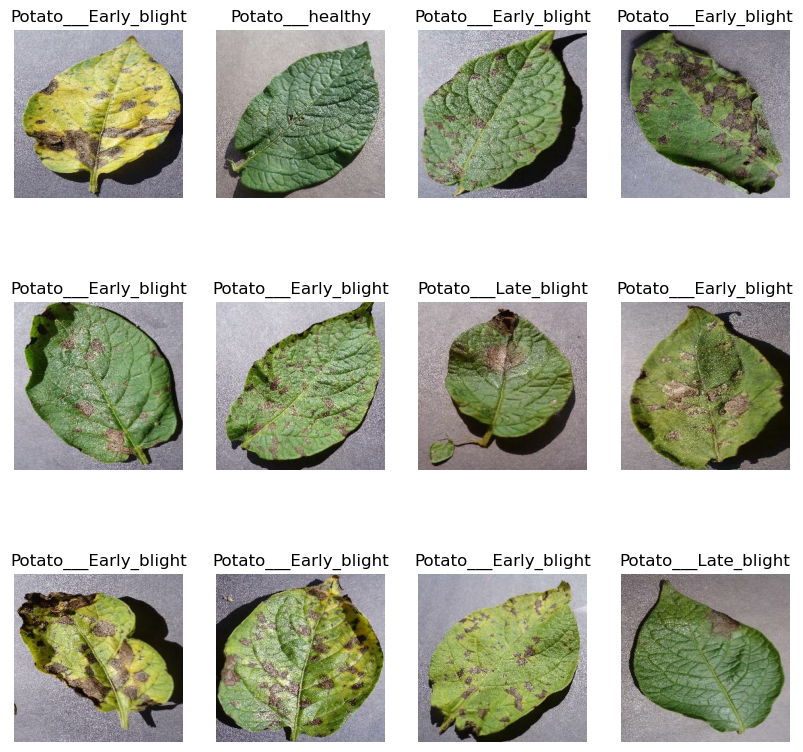

In [16]:
#for visualize images
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
   

In [17]:
#SPLIT data train and test

#tarin = 0.8
#test  = validation 10%   test 10%
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [18]:
train_ds = dataset.take(54)
len(train_ds)

54

In [19]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [20]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [21]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [22]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [23]:
#split 
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1,test_split=0.1, shuffle = True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [24]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [25]:
#prefetch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
#scale
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
    
])

In [27]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)   
])

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3  #model architecture has 3 neurons

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Add dropout to reduce overfitting
    layers.Dense(n_classes, activation='softmax')
])
    
model.build(input_shape=input_shape)    

d:\Anaconda\envs\ds_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
    )


In [32]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
    
)

Epoch 1/50


54/54 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.4562 - loss: 0.9847 - val_accuracy: 0.4740 - val_loss: 0.8911
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.5225 - loss: 0.9004 - val_accuracy: 0.6823 - val_loss: 0.7152
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.6844 - loss: 0.7001 - val_accuracy: 0.7083 - val_loss: 0.6330
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8000 - loss: 0.5092 - val_accuracy: 0.7552 - val_loss: 0.5806
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.8319 - loss: 0.4289 - val_accuracy: 0.7865 - val_loss: 0.4398
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8581 - loss: 0.3671 - val_accuracy: 0.9115 - val_loss: 0.2530
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8833 - loss: 0.3361 - val_accuracy: 0.8542 - val_loss: 0.3220
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.9071 - loss: 0.2795 - val_accuracy: 0.8802 - val_loss: 0.31

In [33]:
history

In [34]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 370ms/step - accuracy: 0.9826 - loss: 0.0359


In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [36]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Losses')

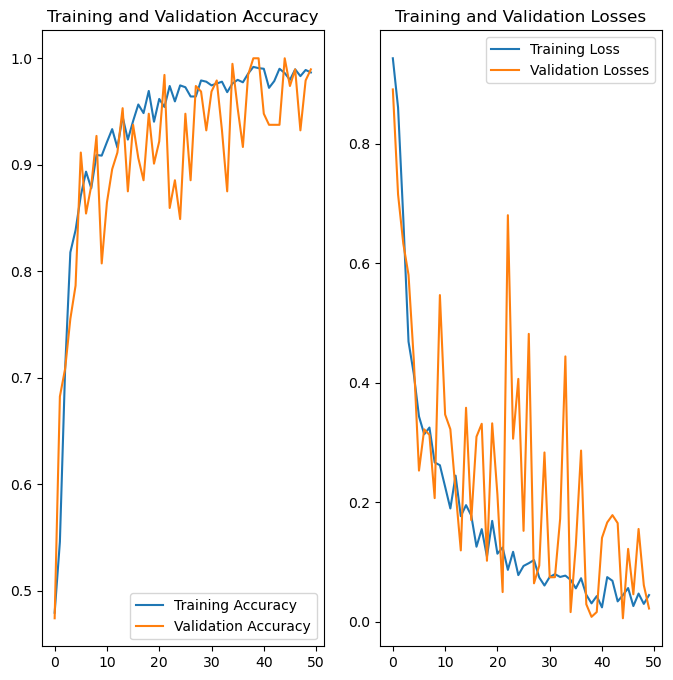

In [38]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Losses')
plt.legend(loc='upper right')
plt.title('Training and Validation Losses')

first image to predict tf.Tensor(2, shape=(), dtype=int32)
actual label: Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
predicted label: Potato___healthy


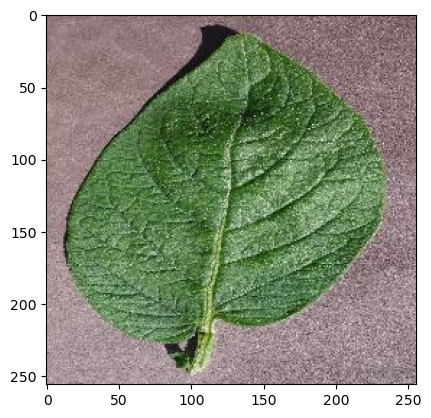

In [48]:
for images, labels in test_ds.take(1):
    
    first_image = images[0].numpy().astype('uint8')
    first_label = labels[0].numpy()
    print("first image to predict", labels[0])
    
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    batch_prediction = model.predict(images)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


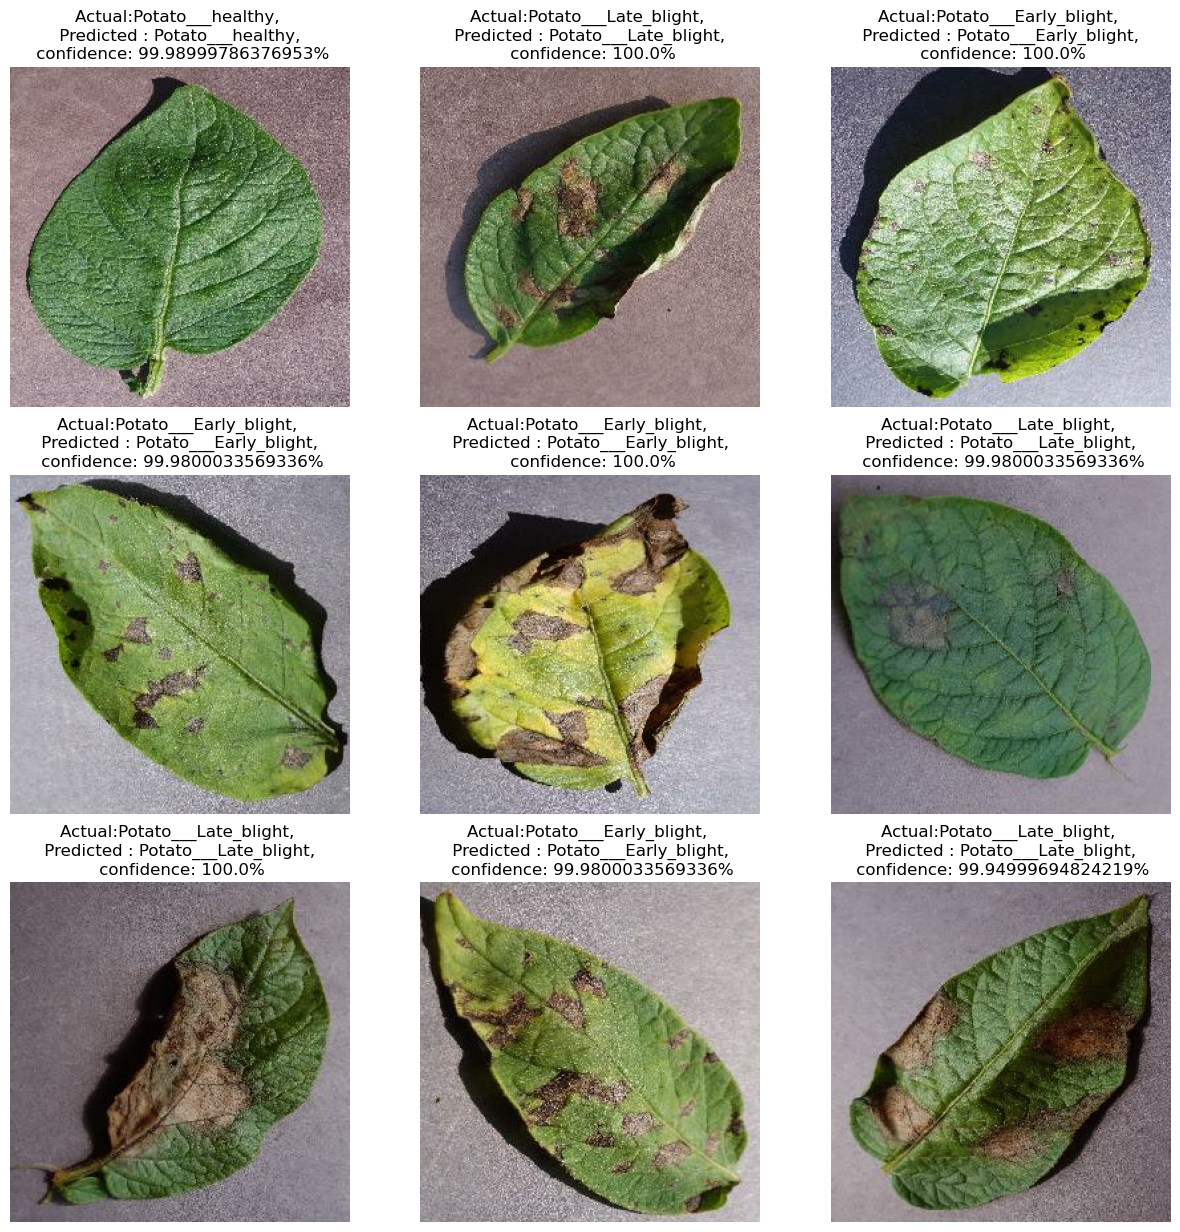

In [50]:

plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class}, \n Predicted : {predicted_class}, \n confidence: {confidence}%")
        plt.axis("off")

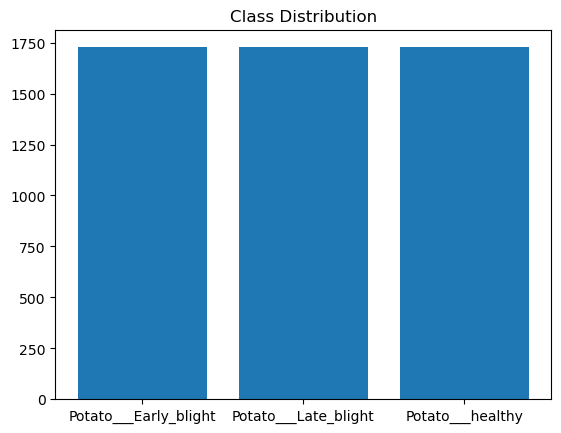

In [43]:
import matplotlib.pyplot as plt

class_counts = {}
for images, labels in train_ds:
    for label in labels:
        cls = np.argmax(label)  # For one-hot encoded labels
        class_counts[cls] = class_counts.get(cls, 0) + 1

plt.bar(class_names, list(class_counts.values()))
plt.title("Class Distribution")
plt.show()

In [60]:
import os
import re

# Define model directory
model_dir = "../models"

# Get existing versions safely
existing_versions = []
for item in os.listdir(model_dir):
    # Match directories with format "{number}_model"
    if os.path.isdir(os.path.join(model_dir, item)):
        match = re.match(r"^(\d+)_model$", item)
        if match:
            existing_versions.append(int(match.group(1)))

# Calculate new version number
model_version = max(existing_versions + [0]) + 1

# Create versioned directory
save_path = os.path.join(model_dir, f"{model_version}_model")
os.makedirs(save_path, exist_ok=True)

# Save model in SavedModel format
model.export(save_path)

print(f"Model saved to: {save_path}")

INFO:tensorflow:Assets written to: ../models\2_model\assets


INFO:tensorflow:Assets written to: ../models\2_model\assets


Saved artifact at '../models\2_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2297794757904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2297794758784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2297784610656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2297784668400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2297784671040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2297784700992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2297784703632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2297784704864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2297784728032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2297784729264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2297784744240: TensorSpec(shape=(